# CISC 867 Project


## Authors

- Dominic Phillips
- Bennet Montgomery

## Important links

- [Original paper](https://paperswithcode.com/paper/unsupervised-any-to-many-audiovisual)
  - [Code](https://github.com/dunbar12138/Audiovisual-Synthesis)
- [Google Drive folder](https://drive.google.com/drive/folders/12O-IlQd4ZM2kxPVJ9hitSUfuSrprPIEC)
- [Project proposal](https://queensuca-my.sharepoint.com/personal/16drp4_queensu_ca/_layouts/15/Doc.aspx?sourcedoc=%7B04585478-D0CA-47C6-B276-3098828A7DAB%7D&file=Project%20Proposal.pptx&action=edit&mobileredirect=true)
- [OnQ deliverables](https://onq.queensu.ca/d2l/le/content/582452/Home)
  - [Project draft](https://onq.queensu.ca/d2l/lms/dropbox/user/folder_submit_files.d2l?db=258790&grpid=593240&isprv=0&bp=0&ou=582452)
    - [Rubric](https://onq.queensu.ca/d2l/lp/rubrics/preview.d2l?ou=582452&rubricId=47677&originTool=quicklinks)
    - [Draft meeting spreadsheet](https://docs.google.com/spreadsheets/d/1ZefaU8afq16ykSjEAJRLccg8th2RtwL6R4Jt-lg6nqM/edit#gid=0)
    - [Overleaf project](https://www.overleaf.com/project/6171e082af75ef1ea42efe1f)
- [Tensorflow tutorial](https://www.tensorflow.org/tutorials/audio/simple_audio#spectrogram)

## Background links

- [What is audio](https://youtu.be/m3XbqfIij_Y)

## What success will look like

- Reproduce the objective acoustic analysis (VCTK) to evaluate the model performance. We should arrive within 0.5 of the SCA value calculated by the paper for their model and 2 for the MCD.​
- Training a model faster than the 3 minutes the paper claims​
- Alternatively, failing to reproduce the objective analysis claimed in the paper and showing the research to be irreproducible. ​

## Impl

### Resources

#### Download VCTK dataset

In [ ]:
#@title VCTK Dataset
Size = "Smaller" #@param ["Full", "Small", "Smaller"]

if Size == "Full":
  vctk_dataset_path = "/content/VCTK-Corpus/"
  archive_path="/content/VCTK-Corpus.tar.gz"
  !test ! -e $archive_path && wget -O $archive_path "https://queensuca-my.sharepoint.com/:u:/g/personal/16drp4_queensu_ca/EcnCAgHdAwBJmWk9vNcpiKgB5Rhi6GNtSchx6zGEhWe-fw?download=1"
  !test ! -e $vctk_dataset_path && tar -xf $archive_path -O $vctk_dataset_path
elif Size == "Small":
  vctk_dataset_path = "/content/VCTK-Corpus-small/"
  !test ! -e /content/VCTK-Corpus-small.7z && wget -O /content/VCTK-Corpus-small.7z "https://queensuca-my.sharepoint.com/:u:/g/personal/16drp4_queensu_ca/Ebz_WoXK4T9KjbJq_SFCsZQB94PqsKOnQ9HwB5olpGeQIw?download=1"
  !test ! -e $vctk_dataset_path && 7z x VCTK-Corpus-small.7z
elif Size == "Smaller":
  vctk_dataset_path = "/content/VCTK-Corpus-smaller/"
  archive_path="/content/VCTK-Corpus-smaller.tar.gz"
  !test ! -e $archive_path && wget -O $archive_path "https://queensuca-my.sharepoint.com/:u:/g/personal/16drp4_queensu_ca/EfRSVbO-ohRFlUFhA9lx4qsBVl4s5FU676hF9uTRSAjOgg?download=1"
  !test ! -e $vctk_dataset_path && tar -xzvf $archive_path


--2021-10-26 22:45:05--  https://queensuca-my.sharepoint.com/:u:/g/personal/16drp4_queensu_ca/EfRSVbO-ohRFlUFhA9lx4qsBVl4s5FU676hF9uTRSAjOgg?download=1
Resolving queensuca-my.sharepoint.com (queensuca-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to queensuca-my.sharepoint.com (queensuca-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/16drp4_queensu_ca/Documents/School%20Files/2021-2023,%20Masters/CISC%20867%20-%20Deep%20Learning/Datasets/VCTK-Corpus-smaller.tar.gz?originalPath=aHR0cHM6Ly9xdWVlbnN1Y2EtbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvMTZkcnA0X3F1ZWVuc3VfY2EvRWZSU1ZiTy1vaFJGbFVGaEE5bHg0cXNCVmw0czVGVTY3NmhGOXVUUlNBak9nZz9ydGltZT1Sbk9qUWRLWTJVZw [following]
--2021-10-26 22:45:06--  https://queensuca-my.sharepoint.com/personal/16drp4_queensu_ca/Documents/School%20Files/2021-2023,%20Masters/CISC%20867%20-%20Deep%20Learning/Datasets/VCTK-Corpus-smaller.tar.gz?originalPath=aHR0cHM6Ly9xdWVlbnN1Y2E

### Imports

In [ ]:
!pip install pydub

In [ ]:
!pip install tensorflow_io

     |████████████████████████████████| 22.7 MB 1.7 MB/s 
     |████████████████████████████████| 2.1 MB 26.5 MB/s 


In [ ]:
# dataset building
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import pandas as pd
# import librosa
import tensorflow_io as tfio

# model building
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
import numpy as np
import math

# debugging and presentation
import matplotlib.pyplot as plt
from pprint import pprint
import IPython

### Acceleration config

In [ ]:
#@title Default title text
acceleration = "GPU" #@param ["CPU", "GPU", "TPU"]

if acceleration == "GPU":
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))
elif acceleration == "TPU":
  # https://www.tensorflow.org/guide/tpu
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))

Found GPU at: /device:GPU:0


#### TPU todo

- https://www.tensorflow.org/guide/tpu
- https://stackoverflow.com/questions/62870656/file-system-scheme-local-not-implemented-in-google-colab-tpu
- https://cloud.google.com/tpu/docs/troubleshooting#cannot_use_local_filesystem
- https://cloud.google.com/tpu/docs/storage-buckets
- https://www.tensorflow.org/datasets/gcs
- https://github.com/tensorflow/models/issues/8265
- https://github.com/sayakpaul/Generating-categories-from-arXiv-paper-titles/blob/master/TPU_Experimentation.ipynb

### Constants

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

### Debug flags

In [ ]:
tf.debugging.set_log_device_placement(True)

### Dataset building

In [ ]:
# read speaker-info.txt file
speaker_info = pd.read_csv(os.path.join(vctk_dataset_path, "speaker-info.txt"), delim_whitespace=True, index_col=False)
# prefix "ID" column with "p" to match folder structure
speaker_info["ID"] = "p" + speaker_info["ID"].astype(str)
# build lookup map
speaker_lookup = {x["ID"]:x for i,x in speaker_info.iterrows()}

In [ ]:
speaker_info

ID  AGE GENDER     ACCENTS    REGION
0    p225   23      F     English  Southern
1    p226   22      M     English    Surrey
2    p227   38      M     English   Cumbria
3    p228   22      F     English  Southern
4    p229   23      F     English  Southern
..    ...  ...    ...         ...       ...
103  p362   29      F    American       NaN
104  p363   22      M    Canadian   Toronto
105  p364   23      M       Irish   Donegal
106  p374   28      M  Australian   English
107  p376   22      M      Indian       NaN

[108 rows x 5 columns]

In [ ]:
speaker_lookup["p225"]

ID             p225
AGE              23
GENDER            F
ACCENTS     English
REGION     Southern
Name: 0, dtype: object

In [50]:
def get_label_from_path(path_tensor):
  parts = tf.strings.split(path_tensor, os.path.sep)
  return parts[-2]
  # return parts[-1]

def get_audio_data_from_path(path_tensor):
  raw = tf.io.read_file(path_tensor)
  wav, sample_rate = tf.audio.decode_wav(raw)
  wav = tf.squeeze(wav, axis=-1)
  return wav

def path_to_audio_mapper(path_tensor):
  audio = get_audio_data_from_path(path_tensor)
  label = get_label_from_path(path_tensor)
  return {
      "audio": audio, 
      "label": label,
      "rate": 48000
  }

In [52]:
audio_paths = tf.io.gfile.glob(os.path.join(vctk_dataset_path, "wav48", "*", "*.wav"))
# ensure reproducible ordering, filesystem not consistent
audio_paths.sort() 

audio_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
audio_ds = audio_ds.map(path_to_audio_mapper)
audio_ds = audio_ds #.cache().prefetch(AUTOTUNE)

for x in audio_ds.take(5):
  print(x)


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
{'audio': <tf.Tensor: shape=(98473,), dtype=float32, numpy=
array([0.00485229, 0.0067749 , 0.0062561 , ..., 0.00817871, 0.00805664,
       0.00878906], dtype=float32)>, 'label': <tf.Tensor: shape=(), dtype=string, numpy=b'p225'>, 'rate': <tf.Tensor: shape=(), dtype=int32, numpy=48000>}
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
{'audio': <tf.Tensor: shape=(194816,), dtype=float

In [53]:
def preview_audio_player(data):
  print(data["label"].numpy().decode("utf-8"))
  IPython.display.display(IPython.display.Audio(data["audio"], rate=data["rate"].numpy()))

# https://www.tensorflow.org/tutorials/audio/simple_audio
def preview_audio_waveforms(data, height=12):
  cols = min(len(data), 3)
  rows = math.ceil(len(data)/cols)
  fig, axes = plt.subplots(rows, cols, figsize=(10, height))
  for i, x in enumerate(data):
    r = i // cols
    c = i % cols
    if len(data) == 1:
      ax = axes
    elif len(data) <= cols:
      ax = axes[c]
    else:
      ax = axes[r][c]
    ax.plot(x["audio"].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = x["label"].numpy().decode("utf-8")
    ax.set_title(label)
  plt.show()

#### Samples

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica

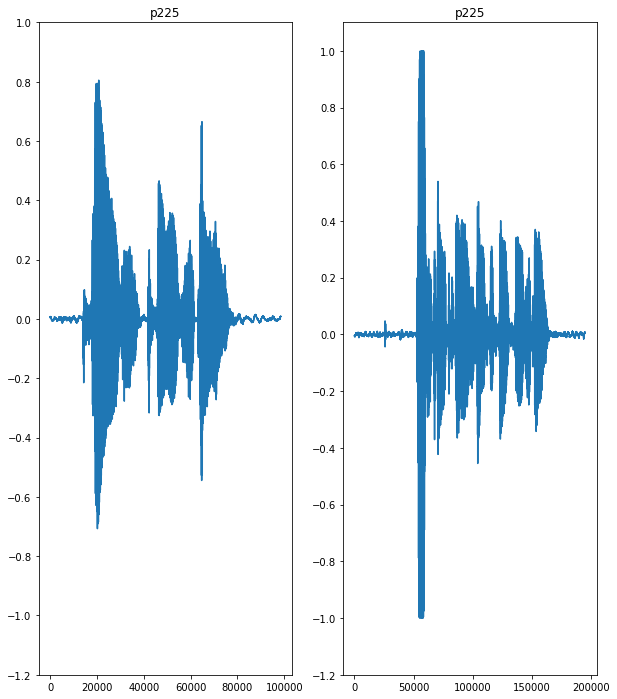

Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
p225


Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
p225


Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0


In [54]:
examples = audio_ds.take(2)
preview_audio_waveforms(examples)
for x in examples:
  preview_audio_player(x)
del examples

### Preprocessing

#### Spectrogram building

In [55]:
# print("Audio max length (prev: 768099)")
# max([len(x["audio"]) for x in audio_ds])

In [56]:
# https://www.tensorflow.org/tutorials/audio/simple_audio#spectrogram
def get_spectrogram(data):
  rate = data["rate"]
  waveform = data["audio"]
  # Padding for files with less than $rate samples
  # todo: we want clips to be the same length
  # print(tf.shape(waveform))
  # if tf.shape(waveform)[0].numpy() < rate:
  zero_padding = tf.zeros([768099] - tf.shape(waveform), dtype=tf.float32)
  waveform = tf.concat([waveform, zero_padding], 0)
  if acceleration == "CPU":
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  elif acceleration == "GPU":
    with tf.device("/GPU:0"):
      spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  elif acceleration == "TPU":
    with tf.device("/TPU:0"):
      spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)

  return spectrogram

def audio_downscale_mapper(audio_tensor):
  audio_tensor["audio"] = tfio.audio.resample(
    audio_tensor["audio"],
    48000,
    16000
  )
  audio_tensor["rate"] = tf.constant(16000)
  return audio_tensor

def preview_spectrogram(data):
  
  spectrogram = get_spectrogram(data)

  audio = data["audio"]
  rate = data["rate"].numpy()


  log_spec = np.log(spectrogram.numpy().T+np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]

  fig, axes = plt.subplots(2, figsize=(12, 8))
  timescale = np.arange(audio.shape[0])
  axes[0].plot(timescale, audio.numpy())
  axes[0].set_title('Waveform')
  axes[0].set_xlim([0, len(timescale)])

  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns). An epsilon is added to avoid log of zero.
  X = np.linspace(0, np.size(spectrogram.numpy()), num=width, dtype=int)
  Y = range(height)
  axes[1].pcolormesh(X, Y, log_spec)
  axes[1].set_title('Spectrogram')
  plt.show()

In [57]:
def audio_to_spectrogram_mapper(audio_tensor):
  spectrogram = get_spectrogram(audio_tensor)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label = audio_tensor["label"]
  # label_id = tf.argmax(label == commands)
  return spectrogram, label

In [58]:
spectrogram_ds = audio_ds.map(audio_to_spectrogram_mapper, num_parallel_calls=AUTOTUNE)

Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


#### Samples

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:loc

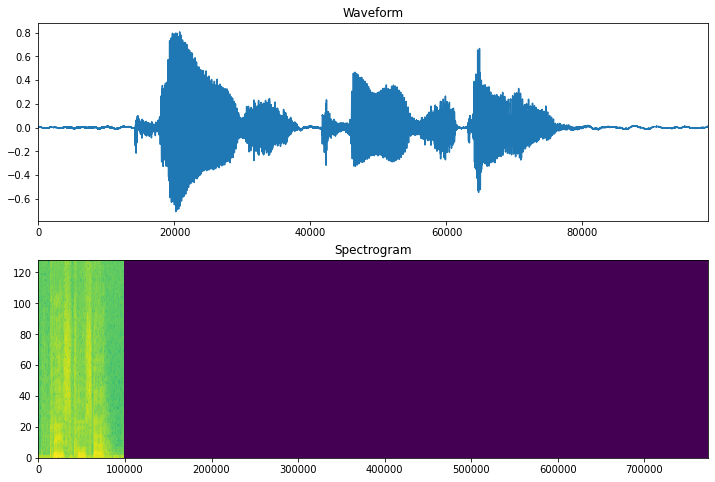

Downsampled
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ExpandDims in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ExpandDims in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_f_5020 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Squeeze in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Shape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:G

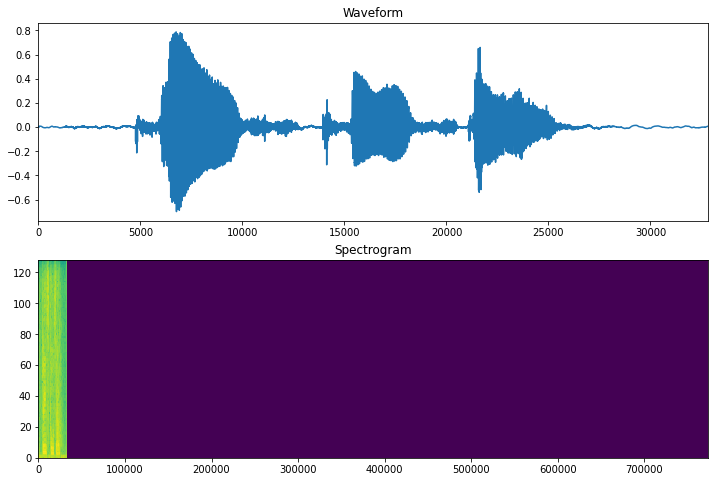

p225


In [59]:
example = list(audio_ds.take(1))[0]
preview_spectrogram(example)

print("Downsampled")
example = audio_downscale_mapper(example)
preview_spectrogram(example)

preview_audio_player(example)
del example

### Dataset splitting

In [60]:
# Seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [61]:
all_ds = spectrogram_ds.shuffle(100)
count = len(all_ds)
train_ds = all_ds.take(count//10*7)#.cache().prefetch(AUTOTUNE)
test_ds = all_ds.skip(len(train_ds))#.cache().prefetch(AUTOTUNE)

print(f"Total samples: {count}")
print(f"Training sample count: {len(train_ds)} ({len(train_ds)/count*100:0.2f}%)")
print(f"Testing sample count: {len(test_ds)} ({len(test_ds)/count*100:0.2f}%)")

Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalAnd in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op SelectV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SkipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Total samples: 2118
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CP

### Dataset batching

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

### Model building

In [64]:
input_shape = list(all_ds.take(1))[0][0].shape
print(f"Input shape: {input_shape}")

num_labels = len(speaker_info)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(all_ds.map(lambda x, _: x))

model = models.Sequential([
  layers.Input(shape = input_shape),
  preprocessing.Resizing(32,32),
  norm_layer,
  layers.Conv2D(32, 3, activation="relu"),
  layers.Conv2D(64, 3, activation="relu"),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation="relu"),
  layers.Dropout(0.5),
  layers.Dense(num_labels)
])

model.summary()

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Input shape: (5999, 129, 1)
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/t

In [68]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


### Model training

In [69]:
EPOCHS = 10
history = model.fit(
  train_ds, 
  validation_data=test_ds,  
  epochs=EPOCHS,
  callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Equal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GreaterEqual in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing

ValueError: ignored

### Debugging 

In [ ]:
shapes = []
for audio, label in train_ds:
  shapes.append(str(audio.shape))
print(set(shapes))

In [49]:
for x in all_ds.take(5):
  print(x)

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
(<tf.Tensor: shape=(5999, 129, 1), dtype=float32, numpy=
array([[[2.69880116e-01],
        [1.21755034e-01],
        [1.37692373e-02],
        ...,
        [7.81659270e-04],
        [2.02642148e-03],
        [2.53434479e-03]],

       [[4.59154099e-01],
        [2.47831404e-01],
        [1.73491258e-02],
        ...,
        [2.60978611e-03],
        [2.00125598e-03],
        [4.73588705e-04]],

       [[5.17197967e-01],
        [2.64453471e-01],
        [4.36410494e-03],
        ...,
        [1.71629956e-03],
        [1.56998902e-03],
        [1.55478716e-03]],

       ...,

       [[0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
      